Generating Metrics Bar Chart...


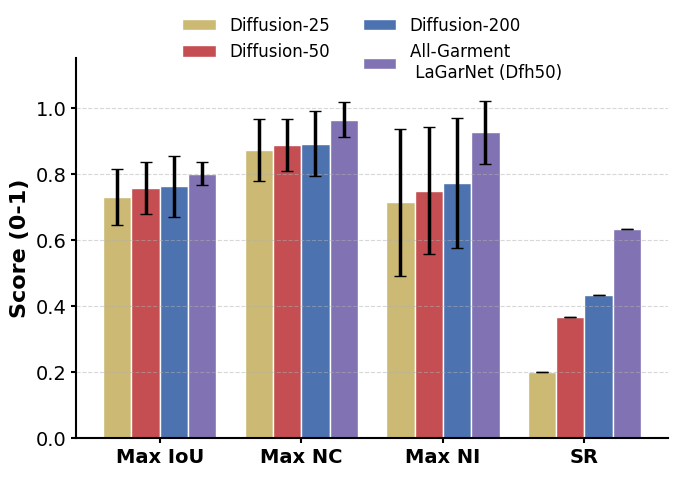

Generating Validation Progression Chart...


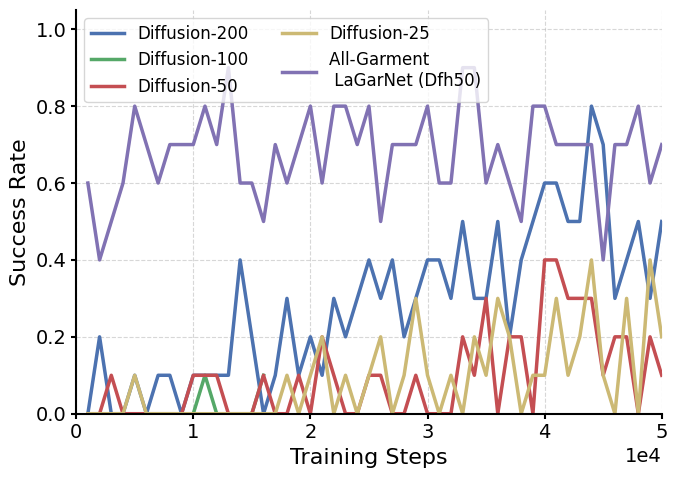

In [1]:
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Publication-Ready Style Settings ---
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'font.family': 'sans-serif',
    'lines.linewidth': 2.5,
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
})

COLORS = {
    'Diffusion-25': '#ccb974',   # Muted Yellow
    'Diffusion-50': '#c44e52',   # Muted Red
    'Diffusion-100': '#55a868',  # Muted Green
    'Diffusion-200': '#4c72b0',  # Muted Blue
    "All-Garment \n LaGarNet (Dfh50)": '#8172b3'        # Muted Purple
}

# --- 2. Helper Functions ---
def parse_list(s):
    if isinstance(s, list): return s
    return ast.literal_eval(s)

def aggregate_performance_custom(csv_path, iou_thresh=0.8, nc_thresh=0.9):
    """Calculates SR (custom criteria), Max IoU, Max NC, and Max NI."""
    df = pd.read_csv(csv_path)
    
    # Parse columns
    df["iou_flat"] = df["evaluation/max_IoU_to_flattened"].apply(parse_list)
    df["nc"] = df["evaluation/normalised_coverage"].apply(parse_list)
    df["ni"] = df["evaluation/normalised_improvement"].apply(parse_list)
    
    # 1. Success Rate (SR)
    new_first_success_flags = []
    for iou_list, nc_list in zip(df["iou_flat"], df["nc"]):
        if any((i > iou_thresh and n > nc_thresh) for i, n in zip(iou_list, nc_list)):
            new_first_success_flags.append(1)
        else:
            new_first_success_flags.append(0)

    # 2. Quality Metrics (Max per episode)
    max_iou = [np.max(x) for x in df["iou_flat"]]
    max_nc = [np.max(x) for x in df["nc"]]
    max_ni = [np.max(x) for x in df["ni"]]

    return {
        "SR_mean": np.mean(new_first_success_flags),
        "SR_std": np.std(new_first_success_flags),
        "Max IoU_mean": np.mean(max_iou), "Max IoU_std": np.std(max_iou),
        "Max NC_mean": np.mean(max_nc),   "Max NC_std": np.std(max_nc),
        "Max NI_mean": np.mean(max_ni),   "Max NI_std": np.std(max_ni),
    }

# --- 3. Plotting Functions ---

def plot_combined_metrics(results_df):
    """
    Grouped Bar Chart: Max IoU, NC, NI, and SR.
    """
    metrics = ["Max IoU", "Max NC", "Max NI", "SR"]
    experiments = results_df["experiment"].unique()
    
    n_groups = len(metrics)
    n_exp = len(experiments)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    
    bar_width = 0.2
    indices = np.arange(n_groups)
    
    for i, exp in enumerate(experiments):
        row = results_df[results_df["experiment"] == exp].iloc[0]
        
        means = []
        stds = []
        for m in metrics:
            means.append(row[f"{m}_mean"])
            if m == "SR":
                stds.append(0) # No error bar for SR
            else:
                stds.append(row[f"{m}_std"])
        
        offset = (i - n_exp/2) * bar_width + bar_width/2
        
        ax.bar(indices + offset, means, bar_width, 
               yerr=stds, capsize=4, 
               label=exp, color=COLORS.get(exp, 'gray'), edgecolor='white')

    ax.set_ylabel('Score (0-1)', fontweight='bold')
    ax.set_xticks(indices)
    ax.set_xticklabels(metrics, fontweight='bold')
    ax.set_ylim(0, 1.15) 
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), 
              ncol=2, frameon=False, fontsize=12)
    
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300)
    plt.show()

def plot_validation_progression(diffusion_csv, lagarnet_csv):
    """
    Combines data from Diffusion and LaGarNet CSVs into one plot.
    """
    fig, ax = plt.subplots(figsize=(7, 5))

    # --- 1. Plot Diffusion Data ---
    if os.path.exists(diffusion_csv):
        df_diff = pd.read_csv(diffusion_csv)
        df_diff = df_diff[(df_diff['Step'] >= 0) & (df_diff['Step'] <= 50000)]
        
        diff_map = [
            ("diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_200", "Diffusion-200"),
            ("diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_100", "Diffusion-100"),
            ("diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_50",  "Diffusion-50"),
            ("diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_25",  "Diffusion-25"),
        ]
        
        for col_prefix, label in diff_map:
            col_mean = f"{col_prefix} - val/success_rate"
            col_min = f"{col_prefix} - val/success_rate__MIN"
            col_max = f"{col_prefix} - val/success_rate__MAX"
            
            if col_mean in df_diff.columns:
                color = COLORS.get(label, 'gray')
                ax.plot(df_diff['Step'], df_diff[col_mean], label=label, color=color)
                if col_min in df_diff.columns and col_max in df_diff.columns:
                    ax.fill_between(df_diff['Step'], df_diff[col_min], df_diff[col_max], color=color, alpha=0.15)
    else:
        print(f"Warning: Diffusion CSV not found: {diffusion_csv}")

    # --- 2. Plot LaGarNet Data ---
    if os.path.exists(lagarnet_csv):
        df_lag = pd.read_csv(lagarnet_csv)
        df_lag = df_lag[(df_lag['Step'] >= 0) & (df_lag['Step'] <= 50000)]
        
        lag_prefix = "lagarnet_single_picker_single_primitive_multi_longsleeve_flattening_sanity_check"
        label = "All-Garment \n LaGarNet (Dfh50)"
        
        col_mean = f"{lag_prefix} - val/success_rate"
        col_min = f"{lag_prefix} - val/success_rate__MIN"
        col_max = f"{lag_prefix} - val/success_rate__MAX"
        
        if col_mean in df_lag.columns:
            color = COLORS.get(label, 'gray')
            ax.plot(df_lag['Step'], df_lag[col_mean], label=label, color=color)
            if col_min in df_lag.columns and col_max in df_lag.columns:
                ax.fill_between(df_lag['Step'], df_lag[col_min], df_lag[col_max], color=color, alpha=0.15)
    else:
        print(f"Warning: LaGarNet CSV not found: {lagarnet_csv}")

    # --- 3. Formatting ---
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Success Rate')
    ax.legend(loc='upper left', frameon=True, fontsize=12, ncol=2)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 50000)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('validation_progression.png', dpi=300)
    plt.show()

# --- 4. Main Execution ---

# PATHS (Update these to your file locations)
data_dir = "/media/hcv530/T7/garment_folding_data"
diffusion_csv = "diffusion_val_success_rate.csv"
lagarnet_csv = "lagarnet_val_success_rate.csv"

# Experiments List (For the Bar Chart)
experiments = [
    {"name": "diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_25", "label": "Diffusion-25", "check": "eval_checkpoint_-2"},
    {"name": "diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_50", "label": "Diffusion-50", "check": "eval_checkpoint_-2"},
    {"name": "diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_100", "label": "Diffusion-100", "check": "eval_checkpoint_-2"},
    {"name": "diffusion_single_picker_single_primitive_multi_longsleeve_flattening_demo_200", "label": "Diffusion-200", "check": "eval_checkpoint_-2"},
    {"name": "lagarnet_single_picker_single_primitive_multi_longsleeve_flattening_sanity_check", "label": "All-Garment \n LaGarNet (Dfh50)", "check": "eval_checkpoint_-2"},
]

# A. Generate Bar Chart Data
rows = []
for exp in experiments:
    path = os.path.join(data_dir, exp["name"], exp["check"], "performance.csv")
    if os.path.exists(path):
        m = aggregate_performance_custom(path, iou_thresh=0.8, nc_thresh=0.9)
        m["experiment"] = exp["label"]
        rows.append(m)
    else:
        # Pass silently if file is missing, or print warning
        # print(f"Warning: Performance file not found for {exp['label']}")
        pass

results_df = pd.DataFrame(rows)

# B. Plot Both Charts
if not results_df.empty:
    print("Generating Metrics Bar Chart...")
    plot_combined_metrics(results_df)

print("Generating Validation Progression Chart...")
plot_validation_progression(diffusion_csv, lagarnet_csv)